### Download dataset from kaggle using kaggle api

In [ ]:
from google.colab import files
# upload the kaggle json file obtained from your kaggle profile
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!rm -r dataset

rm: cannot remove 'dataset': No such file or directory


In [ ]:
%mkdir dataset

In [ ]:
%cd dataset

/content/dataset


In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 338M/346M [00:08<00:00, 43.4MB/s]
100% 346M/346M [00:08<00:00, 41.6MB/s]


In [ ]:
%pwd

'/content/dataset'

In [ ]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:
%cd ../

/content


In [ ]:
%ls

dataset/  sample_data/


### Config

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torchvision.utils import make_grid
from torch.utils.data.dataset import Dataset
from torch.utils.data import WeightedRandomSampler
from PIL import Image

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim 

In [ ]:
train_dataset_path = './dataset/seg_train/seg_train/'
val_dataset_path = './dataset/seg_test/seg_test/'
# test_dataset_path = './dataset/seg_pred/seg_pred/'

### Create train, val dataset

In [ ]:
image_size = 240

In [ ]:
train_transforms = transforms.Compose([
                                        transforms.Resize((image_size, image_size)), 
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(10),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)
                                        ])
val_transforms = transforms.Compose([
                                        transforms.Resize((image_size, image_size)),
                                        transforms.ToTensor(),
                                        # transforms.Normalize(mean, std)
                                        ])
test_transforms = transforms.Compose([
                                        transforms.Resize((image_size, image_size)),
                                        transforms.ToTensor(),
                                        # transforms.Normalize(mean, std)
                                        ])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root=val_dataset_path, transform = train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=val_dataset_path, transform = val_transforms)
# test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform = test_transforms)

In [ ]:
train_dataset.class_to_idx

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

### Data loader

In [ ]:
def build_dataset(batch_size):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size   
    )
    return train_loader, val_loader 

In [ ]:
batch_size = 32
train_loader, val_loader = build_dataset(batch_size)

In [ ]:
sample = iter(train_loader)
images, classes = sample.next()
print(images.shape, classes.shape)

torch.Size([32, 3, 240, 240]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([32, 3, 240, 240])


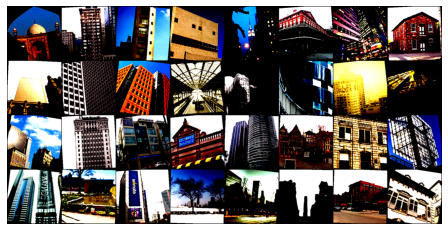

In [ ]:
for images, _ in sample:
    print('images.shape:', images.shape)
    plt.figure(figsize=(10, 4))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

In [ ]:
number_of_samples = len(train_loader) * batch_size
number_of_samples

3008

### Get

In [ ]:
# Experimental: use this to get mean and std for normalizing the data
def get_mean_std(loader):
    count = 0
    mean = 0.
    std = 0.
    total_images_count = 0
    
    for images, _ in tqdm.tqdm(loader):        
        images = images.view(images.size(0), images.size(1), -1)  #4*3*224*224 ->  4*3*(224*224)
        #Computation of mean across all the pixel for each of the 3 kernels and then summing it over complete batch
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    
    mean /= number_of_samples 
    std /= number_of_samples
    return mean, std
    
mean, std = get_mean_std(train_loader) 
print(mean, std)

In [ ]:
mean =  torch.tensor([0.4143, 0.4403, 0.4366])
std = torch.tensor([0.2363, 0.2372, 0.2455])

### Device setup

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Model

In [ ]:
import torch.nn as nn

In [ ]:
import torch

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.cnn_block = nn.Sequential(
        
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),  #(N, 3, 28, 28) -> (N, 6, 24, 24) 48 -> 44
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),                    #(N, 6, 24, 24) -> (N, 6, 12, 12) 44 -> 22
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), #(N, 6, 12, 12) -> (N, 16, 8, 8)  22-> 18
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),                    #(N, 16, 8, 8) -> (N, 16, 4, 4)  18 -> 9
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),#(N, 16, 9, 9) -> (N, 120, 5, 5)
        nn.ReLU() 
    )
    self.linear_block = nn.Sequential(
        nn.Linear(in_features=337080, out_features=84),
        nn.ReLU(),
        nn.Linear(in_features=84, out_features=6)
    )

  def forward(self, x):
    x = self.cnn_block(x)
    # print(x.shape)
    x = x.view(x.size(0), -1)
    # print(x.shape)
    x = self.linear_block(x)
    # print(x.shape)
    return x

In [ ]:
x = torch.randn(8, 3, 240, 240)
model = LeNet()
out = model(x)
out.shape

torch.Size([8, 6])

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=db63b7d2e9eeaab757b56ac10a4ddaac5e08bdc97a3d5f69e50a09ff4faec8d1
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
import torch
num_classes = 6
network = EfficientNet.from_pretrained('efficientnet-b1', num_classes=num_classes)
x = torch.randn(8, 3, 240, 240)
out = network(x)
out.shape

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth



Loaded pretrained weights for efficientnet-b1


torch.Size([8, 6])

### Train setup

#### Evaluation

In [ ]:
def evaluation(dataloader, network):
  total, correct = 0, 0
  for item in dataloader: 
    data, target = item
    data, target = data.to(device), target.to(device)
    logits = network(data)
    pred_val, pred_class = torch.max(logits.data, dim=1)
    total += target.size(0)
    correct += (target==pred_class).sum().item()
  return 100 * correct/total 

#### Single batch overfit

In [ ]:
def overfit_for_single_batch(data, target, network, optimizer, criterion, epochs):
    loss_arr = []

    data, target = data.to(device), target.to(device)
    
    for epoch in tqdm.tqdm(range(epochs)):
        
        optimizer.zero_grad()
        
        logits = network(data)

        # ➡ Forward pass
        loss = criterion(logits, target)        
        loss_arr.append(loss.item())

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        # empty cache
        torch.cuda.empty_cache()

        if epoch%10==0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

    plt.plot(loss_arr)
    plt.show()

In [ ]:
def sanity_check(epochs=50):
    # train_loader, _ = build_dataset(8)
    sample =  iter(train_loader)
    data, target = sample.next()
    # network = build_network(num_classes=5).to(device)
    # criterion = build_criterion(criterion="cross entropy")
    # optimizer = build_optimizer(network, "adam", learning_rate=0.01)
    overfit_for_single_batch(data, target, model, opt, loss_fn, epochs)

#### Entire training

In [ ]:
def fit(trainloader, testloader, model, loss_fn, opt, epochs=16):
  loss_arr = []
  loss_epoch_arr = []
  

  for epoch in tqdm.tqdm(range(epochs)):
    for i, data in enumerate(trainloader, start=0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      
      opt.zero_grad()
      
      outputs = model(inputs)
      
      loss = loss_fn(outputs, labels)

      # loss_arr.append(loss.item())
      
      loss.backward()
      opt.step()
      
      del inputs, labels, outputs
      torch.cuda.empty_cache()



    loss_epoch_arr.append(loss.item())

    print(f"Epoch: {epoch}, Loss:{loss.item()}  Test Accuracy: {evaluation(testloader, model)}, Train Accuracy: {evaluation(trainloader, model)}")
  
  plt.plot(loss_epoch_arr)
  plt.show()

In [ ]:
num_classes = 6
# model = LeNet().to(device)
model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

Loaded pretrained weights for efficientnet-b1


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
fit(train_loader, val_loader, model, loss_fn, opt, epochs=3)

### Sanity check

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

Epoch: 0, Loss: 1.8161906003952026


 22%|██▏       | 11/50 [00:13<00:47,  1.22s/it]

Epoch: 10, Loss: 0.07624003291130066


 42%|████▏     | 21/50 [00:25<00:35,  1.22s/it]

Epoch: 20, Loss: 0.0028966900426894426


 62%|██████▏   | 31/50 [00:37<00:23,  1.22s/it]

Epoch: 30, Loss: 0.0005191371310502291


 82%|████████▏ | 41/50 [00:49<00:10,  1.21s/it]

Epoch: 40, Loss: 0.00031642219983041286


100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


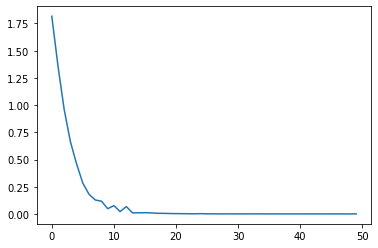

In [ ]:
sanity_check()

### Let's Go!

In [ ]:
torch.cuda.empty_cache()

RuntimeError: ignored

In [ ]:
train()

In [ ]:
evaluation(val_loader, network)

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"